# 1. Predobrada podataka:

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dataframe = pd.read_excel("C:/Users/38164/Master studije/Data Mining/ENB2012_data.xlsx")
dataframe=dataframe.drop(['Unnamed: 10', 'Unnamed: 11'],axis=1)
dataframe.head(10)

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
5,0.90,563.5,318.5,122.50,7.0,3,0.0,0,21.46,25.38
6,0.90,563.5,318.5,122.50,7.0,4,0.0,0,20.71,25.16
7,0.90,563.5,318.5,122.50,7.0,5,0.0,0,19.68,29.60
8,0.86,588.0,294.0,147.00,7.0,2,0.0,0,19.50,27.30
9,0.86,588.0,294.0,147.00,7.0,3,0.0,0,19.95,21.97


Cilj je predvideti Y1 parametar.

### Statisticka analiza podataka:

In [12]:
dataframe.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


### Raspodela podataka:

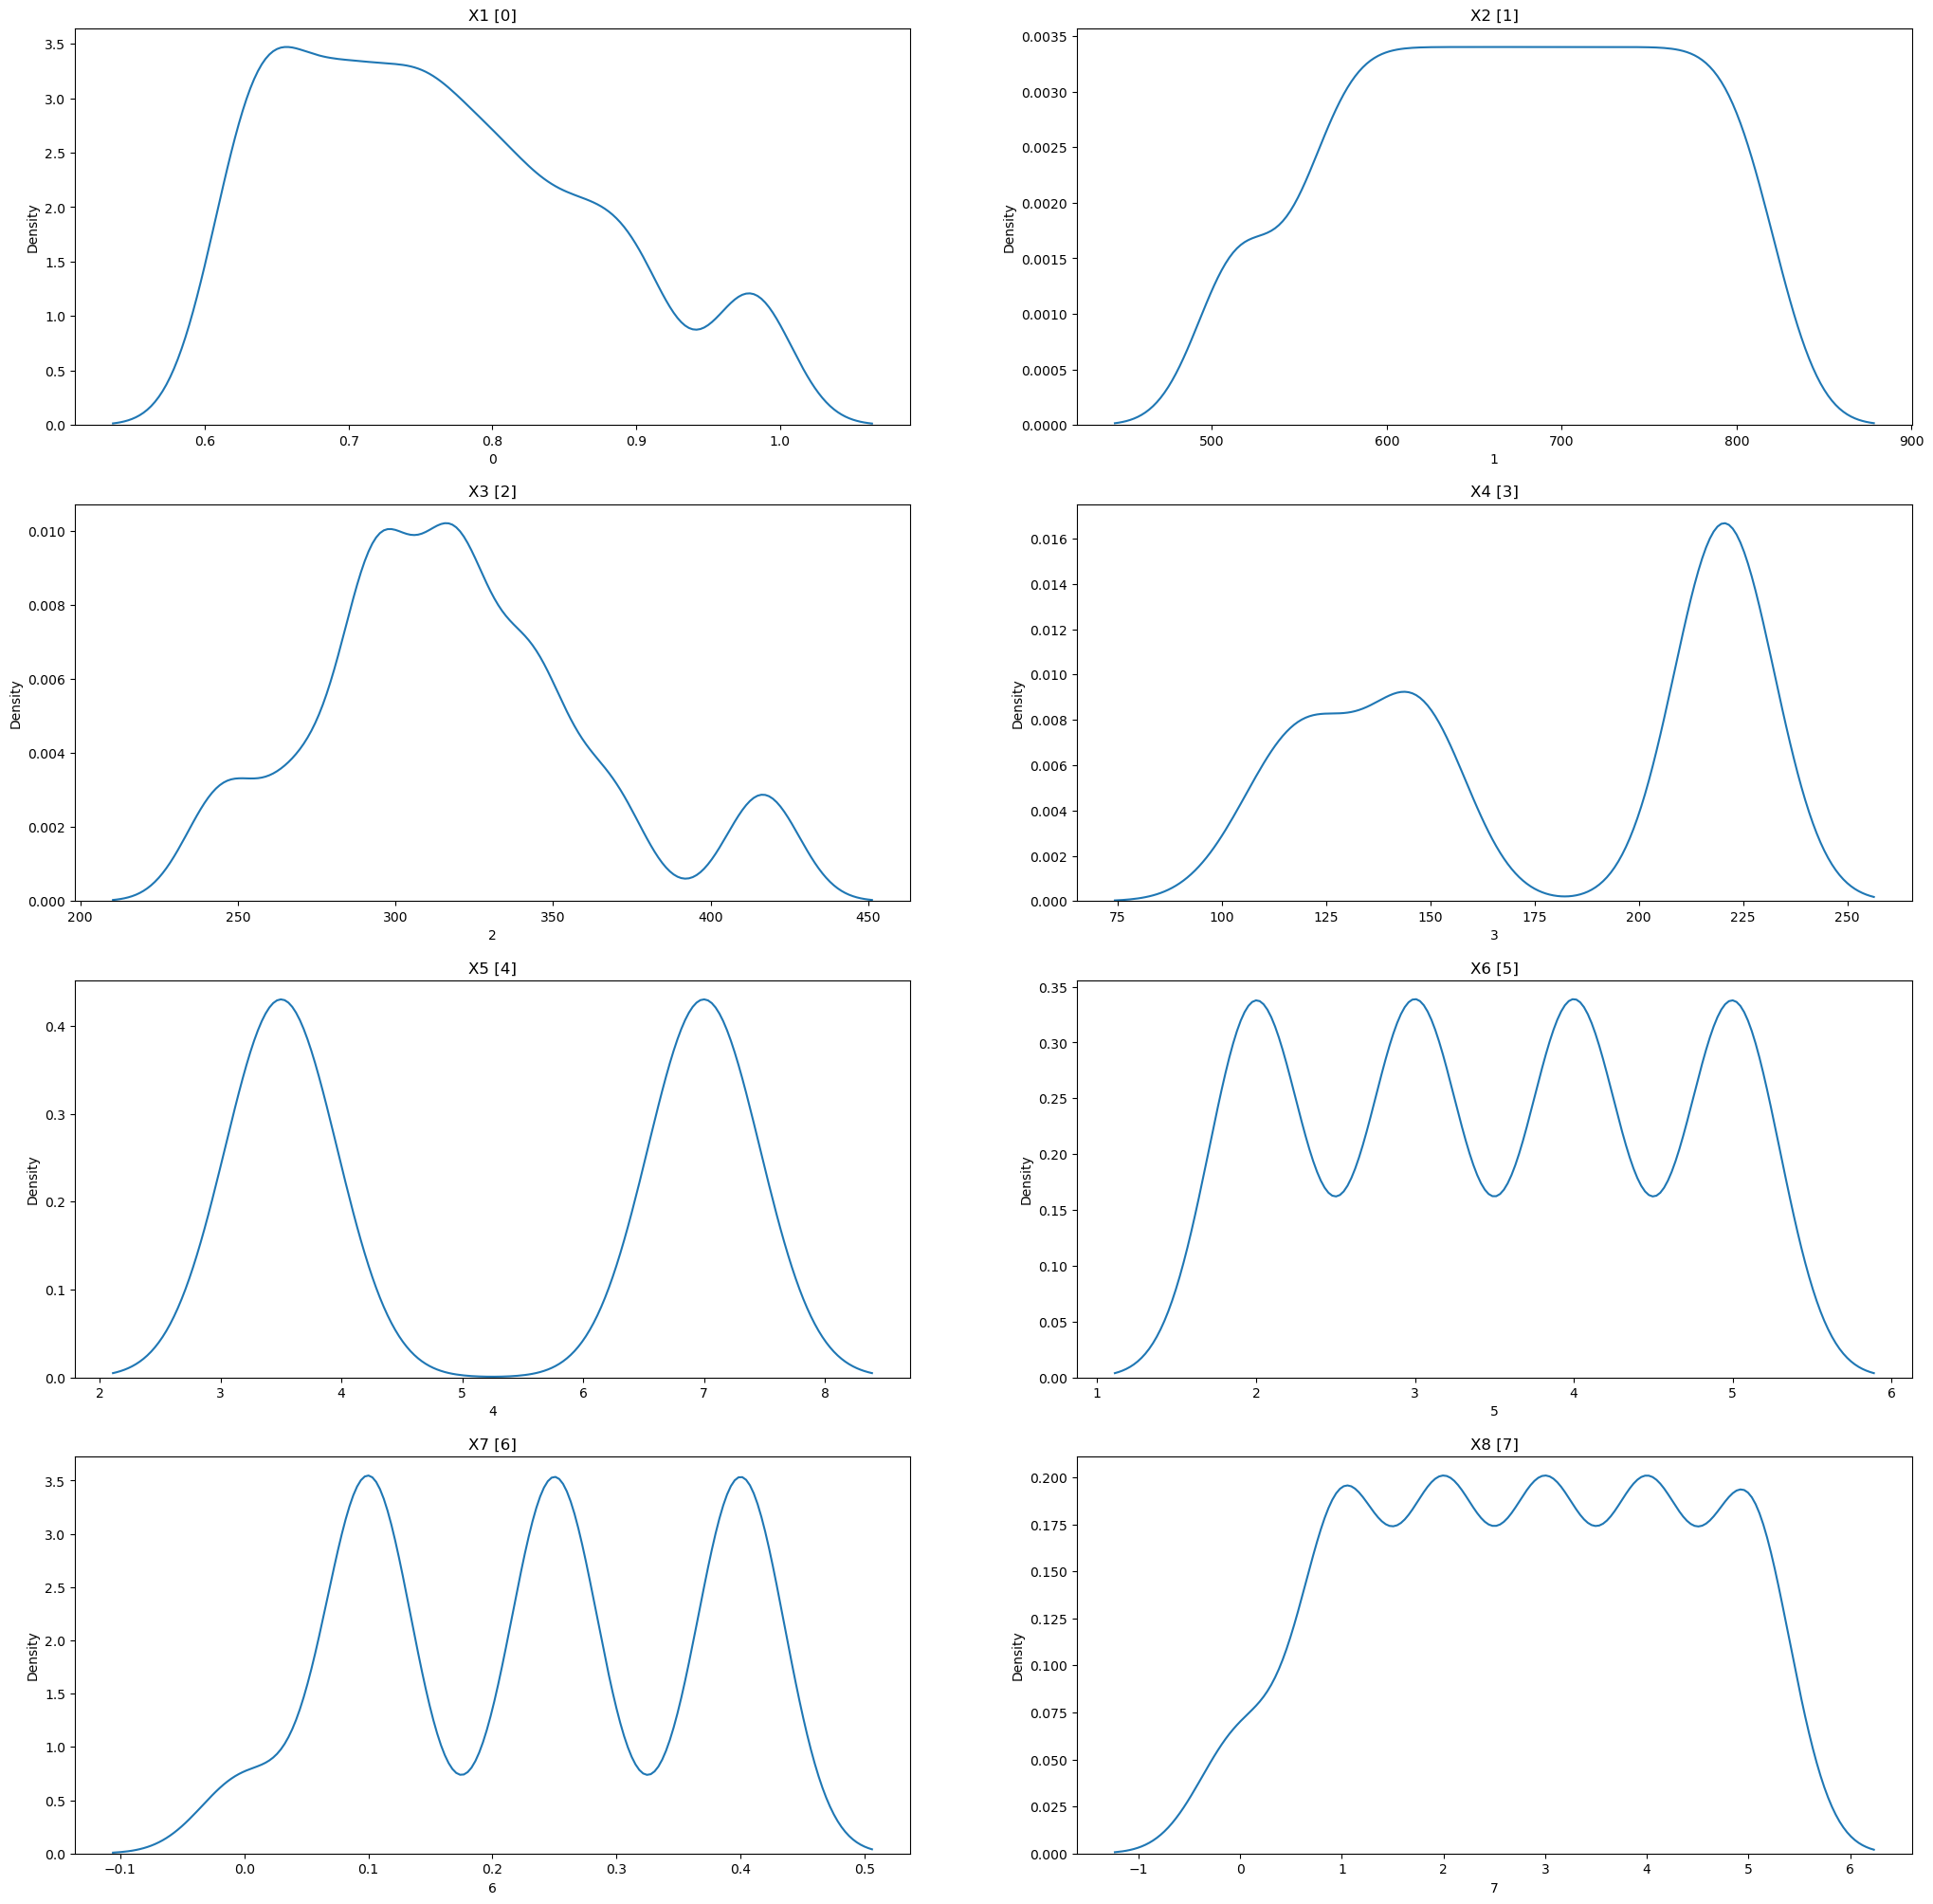

In [13]:
df_hist=dataframe.drop(['Y1','Y2'], axis=1)
potential_features_to_show = df_hist.to_numpy()

mod_df = pd.DataFrame(potential_features_to_show)
fig, axs = plt.subplots(4,2, figsize=(25,25))
for i in range(4):
    for j in range(2):
        sns.kdeplot(mod_df[2*i+j], ax=axs[i][j])
        axs[i][j].set_title('{} [{}]'.format(df_hist.columns[2*i+j],2*i+j))
plt.show()

In [14]:
dataframe.shape

(768, 10)

### Provera nedostajucih vrednosti:

In [15]:
dataframe.isnull().sum()

X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64

### Provera duplikata:

In [16]:
dataframe.drop_duplicates().shape

(768, 10)

### Izbacivanje medjusobno visoko korelisanih feature-a:

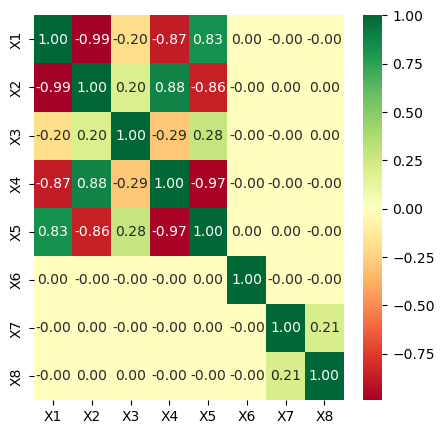

In [18]:
plt.figure(figsize=(5,5))
sns.heatmap(dataframe[dataframe.columns[0:8]].corr(), annot=True, cmap='RdYlGn', fmt='.2f')
plt.show()

Izbacuju se feature-i koji imaju medjusobnu korelaciju cija je apsulutna vrednost veca od 0.95 (izbacuje se samo jedan u paru cija se medjusobna korelacija posmatra).

In [21]:
df_corr=dataframe.drop(['Y1','Y2'], axis=1)
cor_matrix = df_corr[df_corr.columns].corr().abs() 
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_)) 
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['X2', 'X5']


In [22]:
df=dataframe.drop(to_drop,axis=1)
df=df.drop(['Y1','Y2'],axis=1)

### Priprema podataka:

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
potential_features = df.to_numpy()
ss = StandardScaler()
mms = MinMaxScaler()
standardized_features = ss.fit_transform(potential_features)
normalized_features=mms.fit_transform(potential_features)
y1=dataframe['Y1'].to_numpy()
y2=dataframe['Y2'].to_numpy()

# 2. Regresija:

Linearna regresija ce biti implementirana pomocu metoda "najmanjih kvadrata". 
Ovaj metod se koristi za određivanje pribliznog resenja nesaglasnog sistema linearnih jednacina $$Ax = b,$$ gde su $A\in\mathcal{M}_{m\times n}$ matrica sistema punog ranga kolona, $x\in\mathbb{R}^n$ vektor nepoznatih i $b\in\mathbb{R}^m$ vektor slobodnih clanova.  U slucaju kada je ${\rm rang}(A)=n<m$ manji od ${\rm rang}([A|b])=n+1\leq m$ sistem $Ax = b$ nema resenja. U takvoj situaciji upotrebljava se metod najmanjih kvadrata   za pronalazenje pribliznog resenja $\hat{x}$ koje ce minimizirati odstupanje 
$\|b-Ax\|^2.$
To odstupanje ce biti najmanje kada je rezidualni vektor $r=b-Ax$ ortogonalan na prostor kolona matrice $A$, tj. kada je $Ax$ ortogonalna projekcija vektora $b$ na $\mathcal{R}(A).$ 

$$A^Tr=A^T(b-Ax)=\theta$$
$$A^TAx=A^Tb$$
$$\widehat{x}=(A^TA)^{-1}A^Tb$$

$\widehat{x}$ minimizira sumu greska u koordinatama.

In [44]:
A=normalized_features
koefs=np.linalg.inv(A.T@A)@A.T@y1
pred=A@koefs

### Evaluacija:

Za evaluaciju se koristi r-squared. To je statisticka mera koja predstavlja proporciju varijanse zavisne varijable koja se moze objasniti pomocu nezavisnih varijabli u regresionom modelu.
Formula je:
$$R^2=1-\dfrac{neobjasnjena.varijansa}{totalna.varijansa}$$

In [72]:
from sklearn import linear_model

model=linear_model.LinearRegression()
model.fit(A,y1)
pred_skl=model.predict(A)

In [73]:
def r2score(y_pred, y):
    """
    Parameters:
    y_pred: predicted values
    y: actual values
    
    Returns:
    r2: r2 score
    """
    rss = np.sum((y_pred - y) ** 2)
    tss = np.sum((y-y.mean()) ** 2)
    
    r2 = 1 - (rss / tss)
    return r2

In [74]:
r2score(pred,y1),r2score(pred_skl,y1)

(0.822956485417304, 0.8994190046275379)